In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os


# RUN CELL BELOW TO SELECT EXCEL FILE

In [2]:
# open window to select file
from tkinter import Tk
from tkinter.filedialog import askopenfilename

root = Tk()

dir_path = os.path.dirname(os.path.realpath('main.ipynb'))
initial_dir = os.path.join(dir_path, 'Input')
data_path = askopenfilename(initialdir=initial_dir, title='Select file', filetypes=[('all files', '.*'), ('csv files', '.csv'), ('excel files', '.xlsx')])

root.destroy()

print(f'File selected: {data_path}')

DATA_NAME = os.path.basename(data_path)


File selected: C:/Code/Michael/CrayfishBehavior/Input/1.xlsx


In [6]:
# DATA PATH
EXCEL_PATH = data_path

In [ ]:
# # GIVEN PARAMETERS (From ImageJ)
# CONVERSION_RATE = 14.3
# CENTER_X = 327
# CENTER_Y = 258
# FPS = 30
# DURATION = 600

# # DEFINED PARAMETERS

# # Define ExtendedClaw threshold for s1 and s2
# EC_THRESHOLD = 3

# # Define speed threshold for s3 and s4
# SPEED_THRESHOLD_1 = 1
# SPEED_THRESHOLD_2 = 5

# # Define interaction threshold for s5
# INTERACTION_THRESHOLD = 3

# # Define fighting threshold for s6
# FIGHTING_THRESHOLD = 3

# # Define chasing threshold for s7 and s8
# CHASING_THRESHOLD = 3


In [13]:
# import parameters from parameters.json
PARAMS_PATH = 'Bin/parameters.json'
def load_params():
    with open(PARAMS_PATH) as f:
        params = json.load(f)
    # change value type of params from string to int or float
    for key in params:
        if '.' in params[key]:
            params[key] = float(params[key])
        else:
            params[key] = int(params[key])
    return params

params = load_params()


# RUN THE CELLS BELOW TO GET THE DATA

In [7]:
# import xlsx file, sheet = "raw"
df = pd.read_excel(EXCEL_PATH)

df.head()


,individuals,crayfish1,crayfish1.1,crayfish1.2,crayfish1.3,crayfish1.4,crayfish1.5,crayfish1.6,crayfish1.7,crayfish1.8,...,crayfish2.11,crayfish2.12,crayfish2.13,crayfish2.14,crayfish2.15,crayfish2.16,crayfish2.17,crayfish2.18,crayfish2.19,crayfish2.20
0,bodyparts,Rostrum,Rostrum,Rostrum,Head,Head,Head,Telson,Telson,Telson,...,LeftPincer,LeftChelipod,LeftChelipod,LeftChelipod,RightPincer,RightPincer,RightPincer,RightChelipod,RightChelipod,RightChelipod
1,coords,x,y,likelihood,x,y,likelihood,x,y,likelihood,...,likelihood,x,y,likelihood,x,y,likelihood,x,y,likelihood
2,0,479.353,346.903,1,469.414,360.772,1,429.664,399.91,1,...,1,239.79,406.147,1,179.443,365.012,1,208.34,361.755,1
3,1,479.353,346.903,1,469.434,360.797,1,429.695,400.008,1,...,1,239.79,406.147,1,179.736,365.012,1,208.34,361.755,1
4,2,479.358,346.903,1,469.441,360.806,1,429.801,400.032,1,...,1,239.79,406.147,1,179.736,365.012,1,208.34,361.755,1


In [8]:
#get unique values of row index 0
row_0 = df.iloc[0].unique()
row_0  = row_0 [1:]
new_columns = []
for x in row_0:
    new_columns.append(x+"_X")
    new_columns.append(x+"_Y")
    new_columns.append(x+"_likelihood")

# Take the data of crawfish1 from df to a new df called CF1
CF1 = df.iloc[2:,1:len(row_0)*3+1]
# Rename the columns
CF1.columns = new_columns
# Remove columns with _likelihood
CF1 = CF1.loc[:,~CF1.columns.str.contains('_likelihood')]
# Check if CF1 have rows with NaN
if CF1.isnull().values.any():
    print("CF1 has NaN")
else:
    print("CF1 has no NaN")
# Reset Index
CF1 = CF1.reset_index(drop=True)

# Take the data of crawfish2 from df to a new df called CF2
CF2 = df.iloc[2:,len(row_0)*3+1:]
# Rename the columns
CF2.columns = new_columns
# Remove columns with _likelihood
CF2 = CF2.loc[:,~CF2.columns.str.contains('_likelihood')]
# Check if CF2 have rows with NaN
if CF2.isnull().values.any():
    print("CF2 has NaN")
else:
    print("CF2 has no NaN")
# Reset Index
CF2 = CF2.reset_index(drop=True)



CF1 has no NaN
CF2 has no NaN


In [9]:
if len(CF1) == len(CF2):
    FRAMES = len(CF1)
else:
    print('Error: CF1 and CF2 have different length')
    raise ValueError

### 1. PINCERS - EXTENDED CLAW (EC) ANALYSIS

In [14]:
def cheliped_stat(input_df):
    output_dict = {}

    output_dict['distance'] = [] # distance between chelipeds in centimeter
    output_dict['EC'] = []  # 1 = EC, 0 = no EC
    output_dict['EC event counts'] = [] # each consecutive EC counts as 1 "EC event"

    # iterate through rows of CF1
    for index, row in input_df.iterrows():
        # distance=(SQRT((C4-E4)^2+(D4-F4)^2)/$A$4)
        distance = math.sqrt((row['LeftPincer_X'] - row['RightPincer_X'])**2 + (row['LeftPincer_Y'] - row['RightPincer_Y'])**2)/params['CONVERSION_RATE']
        output_dict['distance'].append(distance)
        if distance > params['EC_THRESHOLD']:
            output_dict['EC'].append(1)
        else:
            output_dict['EC'].append(0)
        if index == 0 :
            output_dict['EC event counts'].append(0)
        elif output_dict['EC'][index] == output_dict['EC'][index-1] or output_dict['EC'][index] == 0:
            output_dict['EC event counts'].append(0)
        else:
            output_dict['EC event counts'].append(1)

            

    output_dict['distance'][:5]

    output_dict['avg distance'] = np.mean(output_dict['distance'])

    output_dict['closest distance'] = np.min(output_dict['distance'])

    output_dict['furthest distance'] = np.max(output_dict['distance'])

    output_dict['EC percentage'] = np.sum(output_dict['EC'])/len(output_dict['EC'])*100

    output_dict['Total EC event counts'] = int(np.sum(output_dict['EC event counts']))

    output_dict['Total EC time'] = int(np.sum(output_dict['EC'])/params['FPS'])   # in seconds

    return output_dict

In [15]:
s1 = cheliped_stat(CF1)
s2 = cheliped_stat(CF2)


In [3]:
units = {
    # cheliped_stat
    # 'distance': is a list of distances in cm,
    # 'EC': is a list of 0 and 1,
    # 'EC events': is a dict, with keys are (start,end) frames, values are duration in frames,
    'EC event counts': 'times',
    'avg distance': 'cm',
    'closest distance': 'cm',
    'furthest distance': 'cm',
    'EC percentage': '%',
    'Total EC time': 's',
    
    # movement_stat
    # 'distance': is a list of distance in cm,
    # 'speed': is a list of speed in cm/s,
    # 'slow movements': is a list of 0 and 1,
    # 'medium movements': is a list of 0 and 1,
    # 'rapid movements': is a list of 0 and 1,
    # 'distance to center': is a list of distance to center in cm,
    'total distance': 'cm',
    'avg speed': 'cm/s',
    'freeze time percentage': '%',
    'swimming time percentage': '%',
    'rapid movements time percentage': '%',
    'avg distance to center': 'cm',
    
    # interaction_stat
    # 'distance': is a list of distances in cm,
    # 'interaction': is a list of 0 and 1
    # 'avg distance': 'cm',
    # 'closest distance': 'cm',
    # 'furthest distance': 'cm',
    'interactions percentage': '%',
    # 'interaction events': is a dict, with keys are (start,end) frames, values are duration in frames
    'interaction events percentage': '%',
    'longest duration': 's',

    # fighting_stat
    # 'left side distance': is a list of distance in cm
    # 'right side distance': is a list of distance in cm
    # 'avg distances': is a list of average distance in cm
    # 'fighting' : is a list of 0 and 1
    # 'fighting events': is a dict, with keys are (start,end) frames, values are duration in frames
    'fighting event counts': 'times',
    'fighting time in frames': 'frames',
    'fighting time in seconds': 's',
    'fighting time percentage': '%',
    'longest fighting time in seconds': 's',

    # chasing_stat
    # 'distance': is a list of distance in cm
    # 'chasing' : is a list of 0 and 1
    # 'chasing events': is a dict, with keys are (start,end) frames, values are duration in frames
    # 'avg distance': 'cm',
    # 'closest distance': 'cm',
    # 'furthest distance': 'cm',
    'chasing duration percentage': '%',
    'longest chasing event': 's',
}
import json
save_path = 'units.json'
with open(save_path, 'w') as fp:
    json.dump(units, fp)

### 2. ROSTRUM - MOVEMENT ANALYSIS

In [16]:
def movement_stat(input_df): 
    output_dict = {}

    output_dict['distance'] = []  # Distance between 2 frames in centimeter
    output_dict['speed'] = [] # Speed in cm/s
    output_dict['Slow Movements'] = [] # Speed < THRESHOLD_1
    output_dict['Medium Movements'] = [] # THRESHOLD_1 <= Speed < THRESHOLD_2
    output_dict['Rapid Movements'] = [] # Speed >= THRESHOLD_2
    output_dict['Distance to Center'] = [] # Distance to center in centimeter (dtc)

    # iterate through rows of CF1
    for index, row in input_df.iterrows():
        # Distance to Center = (SQRT(($A$6-C4)^2+($A$8-D4)^2)/$A$4)
        dtc = math.sqrt((params['CENTER_X'] - row['Rostrum_X'])**2 + (params['CENTER_Y'] - row['Rostrum_Y'])**2)/params['CONVERSION_RATE']
        output_dict['Distance to Center'].append(dtc)

        # Distance=SQRT((C5-C4)^2+(D5-D4)^2)/$A$4
        if index == 0:
            continue
        else:
            Distance = math.sqrt((row['Rostrum_X'] - input_df.iloc[index-1]['Rostrum_X'])**2 + (row['Rostrum_Y'] - input_df.iloc[index-1]['Rostrum_Y'])**2)/params['CONVERSION_RATE']
        output_dict['distance'].append(Distance)

        # Speed=E4*$A$10
        Speed = Distance*params['FPS']
        output_dict['speed'].append(Speed)

        # check for Movements type:
        if Speed < params['SPEED_THRESHOLD_1']:
            output_dict['Slow Movements'].append(1)
            output_dict['Medium Movements'].append(0)
            output_dict['Rapid Movements'].append(0)
        elif params['SPEED_THRESHOLD_1'] <= Speed < params['SPEED_THRESHOLD_2']:
            output_dict['Slow Movements'].append(0)
            output_dict['Medium Movements'].append(1)
            output_dict['Rapid Movements'].append(0)
        else:
            output_dict['Slow Movements'].append(0)
            output_dict['Medium Movements'].append(0)
            output_dict['Rapid Movements'].append(1)

    output_dict['Total Distance'] = np.sum(output_dict['distance']) # in cm
    output_dict['Avg Speed'] = np.mean(output_dict['speed']) # in cm/s

    # time ratio = # of Movements / count (in percentage)
    output_dict['Freeze Time Percentage'] = np.sum(output_dict['Slow Movements'])/len(output_dict['Slow Movements'])*100
    output_dict['Swimming Time Percentage'] = np.sum(output_dict['Medium Movements'])/len(output_dict['Medium Movements'])*100
    output_dict['Rapid Movement Time Percentage'] = np.sum(output_dict['Rapid Movements'])/len(output_dict['Rapid Movements'])*100

    # Average distance to center
    output_dict['Avg distance to center'] = np.mean(output_dict['Distance to Center'])

    return output_dict

In [17]:
s3 = movement_stat(CF1)
s4 = movement_stat(CF2)


18001

In [20]:
len(s3['distance'])

18000

In [23]:
for key, value in s3.items():
    try:
        print(key, len(value))
    except:
        print(key, value)

distance 18000
speed 18000
Slow Movements 18000
Medium Movements 18000
Rapid Movements 18000
Distance to Center 18001
Total Distance 719.2871361663133
Avg Speed 1.1988118936105223
Freeze Time Percentage 68.50555555555556
Swimming Time Percentage 27.67222222222222
Rapid Movement Time Percentage 3.822222222222222
Avg distance to center 10.356142924635463


### 3. Interaction time between Crayfishes

In [12]:
def interaction_stat(input_1, input_2):
    inter_cf = {}

    # distance=(SQRT((C4-Q4)^2+(D4-R4)^2)/$A$4)
    inter_cf['distance'] = []
    inter_cf['interactions'] = []

    for i in range(len(input_1)):
        distance = math.sqrt((input_1['Rostrum_X'][i] - input_2['Rostrum_X'][i])**2 + (input_1['Rostrum_Y'][i] - input_2['Rostrum_Y'][i])**2)/params['CONVERSION_RATE']
        inter_cf['distance'].append(distance)
        if distance < params['INTERACTION_THRESHOLD']:
            inter_cf['interactions'].append(1)
        else:
            inter_cf['interactions'].append(0)

    inter_cf['avg distance'] = np.mean(inter_cf['distance'])

    inter_cf['closest distance'] = np.min(inter_cf['distance'])

    inter_cf['furthest distance'] = np.max(inter_cf['distance'])

    inter_cf['interactions percentage'] = np.sum(inter_cf['interactions'])/len(inter_cf['interactions'])*100

    inter_cf['interaction events'] = {}
    for i in range(len(inter_cf['interactions'])):
        if i == 0:
            continue
        if inter_cf['interactions'][i] == 1 and inter_cf['interactions'][i-1] == 0:
            start_point = i
        elif inter_cf['interactions'][i] == 0 and inter_cf['interactions'][i-1] == 1:
            end_point = i
            inter_cf['interaction events'][(start_point, end_point-1)] = end_point - start_point

    # get interaction events percentage of longest duration
    longest_duration = max(inter_cf['interaction events'].values())
    inter_cf['interaction events percentage'] = longest_duration/len(inter_cf['interactions'])*100

    # get longest_duration in seconds
    inter_cf['longest duration'] = longest_duration/params['FPS']

    return inter_cf


In [13]:
s5 = interaction_stat(CF1, CF2)


### 4. Fighting behavior

In [14]:
# View the interaction in the view of CrayFish1
# Measure Pincer distance between 2 crayfishes
def fighting_stat(input_1, input_2):
    output_dict = {}

    output_dict['left side distance'] = []
    output_dict['right side distance'] = []
    output_dict['avg distance'] = []
    output_dict['fighting'] = []
    output_dict['fighting events'] = {}

    for i in range(len(input_1)):
        left_side_distance = math.sqrt((input_1['LeftPincer_X'][i] - input_2['RightPincer_X'][i])**2 + (input_1['LeftPincer_Y'][i] - input_2['RightPincer_Y'][i])**2)/params['CONVERSION_RATE']
        right_side_distance = math.sqrt((input_1['RightPincer_X'][i] - input_2['LeftPincer_X'][i])**2 + (input_1['RightPincer_Y'][i] - input_2['LeftPincer_Y'][i])**2)/params['CONVERSION_RATE']
        avg_distance = (left_side_distance + right_side_distance)/2

        output_dict['left side distance'].append(left_side_distance)
        output_dict['right side distance'].append(right_side_distance)
        output_dict['avg distance'].append(avg_distance)

        if left_side_distance < params['FIGHTING_THRESHOLD'] and right_side_distance < params['FIGHTING_THRESHOLD']:
            output_dict['fighting'].append(1)
        else:
            output_dict['fighting'].append(0)

        # count fighting events
        if i == 0:
            continue
        if output_dict['fighting'][i] == 1 and output_dict['fighting'][i-1] == 0:
            start_point = i
        elif output_dict['fighting'][i] == 0 and output_dict['fighting'][i-1] == 1:
            end_point = i
            output_dict['fighting events'][(start_point, end_point-1)] = end_point - start_point

    output_dict['fighting events count'] = len(output_dict['fighting events'])
    output_dict['fighting time in frames'] = np.sum(output_dict['fighting'])
    output_dict['fighting time in seconds'] = output_dict['fighting time in frames']/params['FPS']
    output_dict['fighting time percentage'] = np.sum(output_dict['fighting'])/len(output_dict['fighting'])*100
    output_dict['longest fighting time in seconds'] = max(output_dict['fighting events'].values())/params['FPS']

    return output_dict
    

In [15]:
s6 = fighting_stat(CF1, CF2)

### 5. Chasing behavior

In [23]:
def chasing_stat(chaser, chased):
    output_dict = {}

    output_dict['distance'] = []  # distance from chaser Rostrum to chased Telson in cm
    output_dict['chasing'] = []
    output_dict['chasing events'] = {}

    for i in range(FRAMES):
        # distance = (SQRT((C4-E4)^2+(D4-F4)^2)/$A$4)
        distance = math.sqrt((chaser['Rostrum_X'][i] - chased['Telson_X'][i])**2 + (chaser['Rostrum_Y'][i] - chased['Telson_Y'][i])**2)/params['CONVERSION_RATE']
        output_dict['distance'].append(distance)

        if distance < params['CHASING_THRESHOLD']:
            output_dict['chasing'].append(1)
        else:
            output_dict['chasing'].append(0)

        # count chasing events
        if i == 0:
            continue
        if output_dict['chasing'][i] == 1 and output_dict['chasing'][i-1] == 0:
            start_point = i
        elif output_dict['chasing'][i] == 0 and output_dict['chasing'][i-1] == 1:
            end_point = i
            output_dict['chasing events'][(start_point, end_point-1)] = end_point - start_point

    output_dict['avg distance'] = np.mean(output_dict['distance'])
    output_dict['closest distance'] = np.min(output_dict['distance'])
    output_dict['furthest distance'] = np.max(output_dict['distance'])
    output_dict['chasing duration percentage'] = np.sum(output_dict['chasing'])/len(output_dict['chasing'])*100
    output_dict['longest chasing event'] = max(output_dict['chasing events'].values())/params['FPS']

    return output_dict

In [24]:
s7 = chasing_stat(chaser = CF1, chased = CF2)
s8 = chasing_stat(CF2, CF1)

In [19]:
s8['chasing duration percentage']

2.583189822787623

In [20]:
def draw_graph(name, target = 'CF1', dataframe1 = CF1, dataframe2 = CF2, width = 20, height = 8):
    # set style
    plt.rcParams['figure.figsize'] = [width, height]
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['ytick.labelsize'] = 15
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.titlesize'] = 20
    plt.rcParams['legend.fontsize'] = 15
    plt.rcParams['lines.linewidth'] = 2
    plt.rcParams['lines.markersize'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.linewidth'] = 0.5

    #target is either CF1 or CF2
    assert target == 'CF1' or target == 'CF2', 'target must be either CF1 or CF2'
    if target == 'CF1':
        target_df = CF1
    else:
        target_df = CF2

    if name == 'cheliped':
        target_dict = cheliped_stat(target_df)
        # plot distance to frames
        plt.plot(target_dict['distance'])
        plt.xlabel('Frames')
        plt.ylabel('Distance (cm)')
        plt.title('Distance between left and right pincers of ' + target)
    
    elif name == 'rostrum':
        target_dict = interaction_stat()
        # plot distance to frames
        plt.plot(target_dict['distance'])
        plt.xlabel('Frames')
        plt.ylabel('Distance (cm)')
        plt.title('Distance between two crayfishes')

    elif name == 'fighting':
        target_dict = fighting_stat()
        # plot average distance to frames
        plt.plot(target_dict['avg distance'])
        plt.xlabel('Frames')
        plt.ylabel('Distance (cm)')
        plt.title('Average distance between two crayfishes')

    elif name == 'chasing':
        if target == 'CF1':
            chaser = dataframe1
            chased = dataframe2
        else:
            chaser = dataframe2
            chased = dataframe1
        target_dict = chasing_stat(target_df)
        # plot distance to frames
        plt.plot(target_dict['distance'])
        plt.xlabel('Frames')
        plt.ylabel('Distance (cm)')
        chaser_num = target.split('CF')[1]
        chased_num = '2' if chaser_num == '1' else '1'
        plt.title(f"Distance between Rostrum of CrayFish {chaser_num} and Telson of Crayfish {chased_num}")


    plt.show()


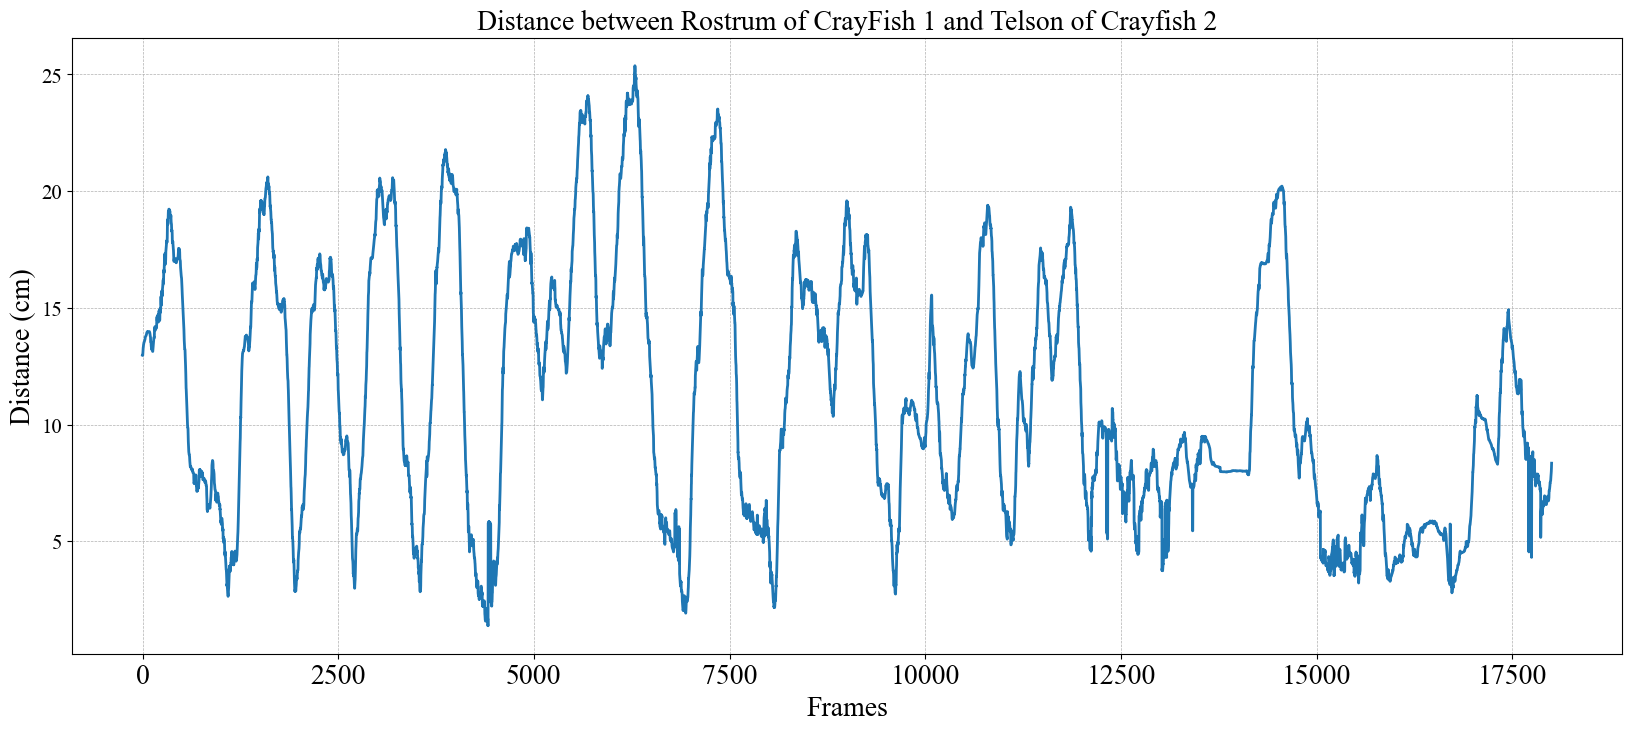

In [21]:
draw_graph('chasing', target = 'CF1', width = 20, height = 8)

In [4]:
# write a .bat file to run pip install -r requirements.txt
with open('install.bat', 'w') as f:
    f.write('pip install -r requirements.txt')
